In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T

from sklearn.preprocessing import MinMaxScaler
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load HR data

In [3]:
hr_patches_file_path = "D:\\Hemanth\\Dataset\\IP_hr_patches.mat"
hr_patches_data = loadmat(hr_patches_file_path)

num_patches = 1601

hr_patches_list = [hr_patches_data[f'hr_patch_{i}'] for i in range(1, num_patches)]

hr_patches_array = np.array(hr_patches_list, dtype=np.float32)

reshaped_array = hr_patches_array.reshape(-1, hr_patches_array.shape[-1])

# Normalize the patches
scaler = MinMaxScaler()
normalized_array = scaler.fit_transform(reshaped_array)

total_array = normalized_array.reshape(hr_patches_array.shape)

normalized_hr_patches_array = total_array[:1200]

hr_patches_tensor = torch.tensor(normalized_hr_patches_array).to(device)

print("Shape of High-Resolution Patches Tensor:", hr_patches_tensor.shape)
print(hr_patches_tensor.min(), hr_patches_tensor.max())

Shape of High-Resolution Patches Tensor: torch.Size([1200, 66, 66, 200])
tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


In [4]:
normalized_test_hr_array = total_array[1200:]

test_hr_patches_tensor = torch.tensor(normalized_test_hr_array).to(device)

print("Shape of High-Resolution Patches Tensor:", test_hr_patches_tensor.shape)
print(test_hr_patches_tensor.min(), test_hr_patches_tensor.max())

Shape of High-Resolution Patches Tensor: torch.Size([400, 66, 66, 200])
tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


In [5]:
hr_patches_tensor = hr_patches_tensor.unsqueeze(4)
hr_patches_tensor = hr_patches_tensor.permute(0, 3, 1, 2, 4)
hr_patches_tensor.shape

torch.Size([1200, 200, 66, 66, 1])

In [6]:
test_hr_patches_tensor = test_hr_patches_tensor.unsqueeze(4)
test_hr_patches_tensor = test_hr_patches_tensor.permute(0, 3, 1, 2, 4)
test_hr_patches_tensor.shape

torch.Size([400, 200, 66, 66, 1])

# Load LR data

In [7]:
from scipy.ndimage import zoom

bilinear_lr_patches_file_path = "D:\\Hemanth\\Dataset\\IP_lr_patches_bilinear.mat"
bilinear_lr_patches_data = loadmat(bilinear_lr_patches_file_path)

num_patches = 1601

bilinear_lr_patches_list = [bilinear_lr_patches_data[f'lr_patch_{i}'] for i in range(1, num_patches)]

upsampled_lr_patches_array = np.array([zoom(patch, zoom=(3,3,1), order=3) for patch in bilinear_lr_patches_list], dtype=np.float32)

reshaped_upsampled_lr_array = upsampled_lr_patches_array.reshape(-1, upsampled_lr_patches_array.shape[-1])

normalized_lr_array = scaler.fit_transform(reshaped_upsampled_lr_array)

total_lr_array = normalized_lr_array.reshape((num_patches-1, 66, 66, 200))

normalized_lr_patches_array = total_lr_array[:1200]

bilinear_lr_patches_tensor = torch.tensor(normalized_lr_patches_array).to(device)

print("Shape of High-Resolution Patches Tensor:", bilinear_lr_patches_tensor.shape)
print(bilinear_lr_patches_tensor.min(), bilinear_lr_patches_tensor.max())

Shape of High-Resolution Patches Tensor: torch.Size([1200, 66, 66, 200])
tensor(0., device='cuda:0') tensor(1.0000, device='cuda:0')


In [8]:
normalized_test_lr_array = total_lr_array[1200:]

test_bilinear_lr_patches_tensor = torch.tensor(normalized_test_lr_array).to(device)

print("Shape of High-Resolution Patches Tensor:", test_bilinear_lr_patches_tensor.shape)
print(test_bilinear_lr_patches_tensor.min(), test_bilinear_lr_patches_tensor.max())

Shape of High-Resolution Patches Tensor: torch.Size([400, 66, 66, 200])
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [9]:
bilinear_lr_patches_tensor = bilinear_lr_patches_tensor.unsqueeze(4)
bilinear_lr_patches_tensor = bilinear_lr_patches_tensor.permute(0, 3, 1, 2, 4)
bilinear_lr_patches_tensor.shape

torch.Size([1200, 200, 66, 66, 1])

In [10]:
test_bilinear_lr_patches_tensor = test_bilinear_lr_patches_tensor.unsqueeze(4)
test_bilinear_lr_patches_tensor = test_bilinear_lr_patches_tensor.permute(0, 3, 1, 2, 4)
test_bilinear_lr_patches_tensor.shape

torch.Size([400, 200, 66, 66, 1])

# PARAMETERS

In [11]:
num_channels = hr_patches_tensor.shape[1]
hr_dimensions = hr_patches_tensor.shape[2]
lr_dimensions = bilinear_lr_patches_tensor.shape[2]
batch_size = 30

print(num_channels, hr_dimensions, lr_dimensions)

200 66 66


# Data Loader

In [12]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, hr_data, lr_data):
        self.hr_data = hr_data
        self.lr_data = lr_data

    def __len__(self):
        return len(self.hr_data)

    def __getitem__(self, idx):
        hr_sample = self.hr_data[idx]
        lr_sample = self.lr_data[idx]
        return hr_sample, lr_sample


In [13]:
custom_dataset = CustomDataset(hr_patches_tensor, bilinear_lr_patches_tensor)
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# MODEL

In [15]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv3d(num_channels, 512, (9,9,1), 1, (4,4,0))
        self.conv2 = nn.Conv3d(512, 256, (9,9,1), 1, (4,4,0))
        self.conv3 = nn.Conv3d(256, 128, (9,9,1), 1, (4,4,0))
        self.conv4 = nn.Conv3d(128, 64, (5,5,1), 1, (2,2,0))
        self.conv5 = nn.Conv3d(64, num_channels, (5,5,1), 1, (2,2,0))

        self.bn1 = nn.BatchNorm3d(512)
        self.bn2 = nn.BatchNorm3d(256)
        self.bn3 = nn.BatchNorm3d(128)
        self.bn4 = nn.BatchNorm3d(64)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)

        return x

model = SRCNN().to(device)
print(model)

SRCNN(
  (conv1): Conv3d(200, 512, kernel_size=(9, 9, 1), stride=(1, 1, 1), padding=(4, 4, 0))
  (conv2): Conv3d(512, 256, kernel_size=(9, 9, 1), stride=(1, 1, 1), padding=(4, 4, 0))
  (conv3): Conv3d(256, 128, kernel_size=(9, 9, 1), stride=(1, 1, 1), padding=(4, 4, 0))
  (conv4): Conv3d(128, 64, kernel_size=(5, 5, 1), stride=(1, 1, 1), padding=(2, 2, 0))
  (conv5): Conv3d(64, 200, kernel_size=(5, 5, 1), stride=(1, 1, 1), padding=(2, 2, 0))
  (bn1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


# TRAIN

In [16]:
def calculate_psnr(prediction, target):
    mse = torch.mean((prediction - target) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

def rmse_loss(input, target):
    return torch.sqrt(F.mse_loss(input, target))

def sam_loss(input, target):
    input_norm = F.normalize(input.reshape(input.size(0), -1), dim=1)
    target_norm = F.normalize(target.reshape(target.size(0), -1), dim=1)
    return torch.acos((input_norm * target_norm).sum(dim=1)).mean()

In [17]:
lr = 0.0001
num_epochs = 150

lambda_rmse = 1.0
lambda_sam = 0.8

In [18]:

optimizer = optim.Adam([
        {'params': model.conv1.parameters()},
        {'params': model.conv2.parameters()},
        {'params': model.conv3.parameters()},
        {'params': model.conv4.parameters()},
        {'params': model.conv5.parameters(), 'lr': lr * 0.1}
    ], lr=lr)

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

In [19]:
epoch_losses = []
psnr_values = []

for epoch in range(num_epochs):
    epoch_loss_meter = AverageMeter()
    epoch_psnr_meter = AverageMeter()
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # for lr_batch, hr_batch in tqdm(zip(lr_data_loader, hr_data_loader), total=len(lr_data_loader)):
    for hr_batch, lr_batch in tqdm(data_loader, total=len(data_loader)):
        lr_patch = lr_batch
        hr_patch = hr_batch

        lr_patch = lr_patch.to(device)
        hr_patch = hr_patch.to(device)

        model.train()
        optimizer.zero_grad()

        preds = model(lr_patch)

        rmse_loss_value = rmse_loss(preds, hr_patch)
        sam_loss_value = sam_loss(preds, hr_patch)

        total_loss = lambda_rmse*rmse_loss_value + lambda_sam*sam_loss_value

        total_loss.backward()
        optimizer.step()

        epoch_loss_meter.update(total_loss.item(), len(lr_patch))

        # Calculate PSNR
        psnr = calculate_psnr(preds, hr_patch)
        epoch_psnr_meter.update(psnr)

    # Append epoch losses and PSNR values
    epoch_losses.append(epoch_loss_meter.avg)
    psnr_values.append(epoch_psnr_meter.avg)

    print(f"Epoch Loss: {epoch_loss_meter.avg:.6f}, Avg PSNR: {epoch_psnr_meter.avg:.2f} dB, Avg RMSE Loss: {rmse_loss_value:.6f}, Avg SAM Loss: {sam_loss_value:.6f}")


Epoch [1/150]


100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Epoch Loss: 1.253965, Avg PSNR: 7.87 dB, Avg RMSE Loss: 0.321902, Avg SAM Loss: 0.712261
Epoch [2/150]


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Epoch Loss: 0.666828, Avg PSNR: 11.98 dB, Avg RMSE Loss: 0.198753, Avg SAM Loss: 0.380861
Epoch [3/150]


100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Epoch Loss: 0.401781, Avg PSNR: 16.30 dB, Avg RMSE Loss: 0.125709, Avg SAM Loss: 0.256891
Epoch [4/150]


100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Epoch Loss: 0.292874, Avg PSNR: 19.38 dB, Avg RMSE Loss: 0.097624, Avg SAM Loss: 0.212955
Epoch [5/150]


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Epoch Loss: 0.258992, Avg PSNR: 20.50 dB, Avg RMSE Loss: 0.088750, Avg SAM Loss: 0.194392
Epoch [6/150]


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Epoch Loss: 0.241465, Avg PSNR: 21.10 dB, Avg RMSE Loss: 0.086982, Avg SAM Loss: 0.187765
Epoch [7/150]


100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Epoch Loss: 0.233075, Avg PSNR: 21.40 dB, Avg RMSE Loss: 0.086649, Avg SAM Loss: 0.184433
Epoch [8/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.224276, Avg PSNR: 21.74 dB, Avg RMSE Loss: 0.082771, Avg SAM Loss: 0.177602
Epoch [9/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.216450, Avg PSNR: 22.04 dB, Avg RMSE Loss: 0.076833, Avg SAM Loss: 0.167553
Epoch [10/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.208566, Avg PSNR: 22.36 dB, Avg RMSE Loss: 0.073850, Avg SAM Loss: 0.161424
Epoch [11/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.202422, Avg PSNR: 22.61 dB, Avg RMSE Loss: 0.072774, Avg SAM Loss: 0.157472
Epoch [12/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.198488, Avg PSNR: 22.77 dB, Avg RMSE Loss: 0.070513, Avg SAM Loss: 0.151830
Epoch [13/150]


100%|██████████| 40/40 [00:16<00:00,  2.35it/s]


Epoch Loss: 0.191768, Avg PSNR: 23.09 dB, Avg RMSE Loss: 0.069631, Avg SAM Loss: 0.151618
Epoch [14/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.187539, Avg PSNR: 23.27 dB, Avg RMSE Loss: 0.068090, Avg SAM Loss: 0.146938
Epoch [15/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.185856, Avg PSNR: 23.34 dB, Avg RMSE Loss: 0.068366, Avg SAM Loss: 0.147986
Epoch [16/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.180746, Avg PSNR: 23.59 dB, Avg RMSE Loss: 0.065513, Avg SAM Loss: 0.143835
Epoch [17/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.176483, Avg PSNR: 23.80 dB, Avg RMSE Loss: 0.064852, Avg SAM Loss: 0.138361
Epoch [18/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.172547, Avg PSNR: 24.00 dB, Avg RMSE Loss: 0.061721, Avg SAM Loss: 0.133745
Epoch [19/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.169015, Avg PSNR: 24.18 dB, Avg RMSE Loss: 0.061555, Avg SAM Loss: 0.134820
Epoch [20/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.169056, Avg PSNR: 24.16 dB, Avg RMSE Loss: 0.061091, Avg SAM Loss: 0.132937
Epoch [21/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.165426, Avg PSNR: 24.36 dB, Avg RMSE Loss: 0.059020, Avg SAM Loss: 0.128487
Epoch [22/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.162797, Avg PSNR: 24.49 dB, Avg RMSE Loss: 0.059289, Avg SAM Loss: 0.126920
Epoch [23/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.161857, Avg PSNR: 24.53 dB, Avg RMSE Loss: 0.061719, Avg SAM Loss: 0.128837
Epoch [24/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.159800, Avg PSNR: 24.66 dB, Avg RMSE Loss: 0.056973, Avg SAM Loss: 0.123161
Epoch [25/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.156244, Avg PSNR: 24.87 dB, Avg RMSE Loss: 0.056339, Avg SAM Loss: 0.121851
Epoch [26/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.154504, Avg PSNR: 24.96 dB, Avg RMSE Loss: 0.057522, Avg SAM Loss: 0.120657
Epoch [27/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.152547, Avg PSNR: 25.06 dB, Avg RMSE Loss: 0.055050, Avg SAM Loss: 0.118557
Epoch [28/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.149910, Avg PSNR: 25.22 dB, Avg RMSE Loss: 0.055045, Avg SAM Loss: 0.119088
Epoch [29/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.177249, Avg PSNR: 23.64 dB, Avg RMSE Loss: 0.062558, Avg SAM Loss: 0.136671
Epoch [30/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.161271, Avg PSNR: 24.55 dB, Avg RMSE Loss: 0.056722, Avg SAM Loss: 0.121976
Epoch [31/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.152231, Avg PSNR: 25.07 dB, Avg RMSE Loss: 0.055617, Avg SAM Loss: 0.117796
Epoch [32/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.149638, Avg PSNR: 25.22 dB, Avg RMSE Loss: 0.053432, Avg SAM Loss: 0.115678
Epoch [33/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.147076, Avg PSNR: 25.36 dB, Avg RMSE Loss: 0.056293, Avg SAM Loss: 0.114628
Epoch [34/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.145535, Avg PSNR: 25.46 dB, Avg RMSE Loss: 0.054954, Avg SAM Loss: 0.120924
Epoch [35/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.143601, Avg PSNR: 25.59 dB, Avg RMSE Loss: 0.052313, Avg SAM Loss: 0.112462
Epoch [36/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.142069, Avg PSNR: 25.67 dB, Avg RMSE Loss: 0.052043, Avg SAM Loss: 0.112309
Epoch [37/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.141327, Avg PSNR: 25.72 dB, Avg RMSE Loss: 0.051249, Avg SAM Loss: 0.110293
Epoch [38/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.139475, Avg PSNR: 25.84 dB, Avg RMSE Loss: 0.050329, Avg SAM Loss: 0.110316
Epoch [39/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.139208, Avg PSNR: 25.84 dB, Avg RMSE Loss: 0.050997, Avg SAM Loss: 0.112294
Epoch [40/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.137923, Avg PSNR: 25.94 dB, Avg RMSE Loss: 0.050428, Avg SAM Loss: 0.108566
Epoch [41/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.136110, Avg PSNR: 26.05 dB, Avg RMSE Loss: 0.048623, Avg SAM Loss: 0.105780
Epoch [42/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.135578, Avg PSNR: 26.07 dB, Avg RMSE Loss: 0.049294, Avg SAM Loss: 0.106962
Epoch [43/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.134842, Avg PSNR: 26.13 dB, Avg RMSE Loss: 0.049629, Avg SAM Loss: 0.107593
Epoch [44/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.133974, Avg PSNR: 26.20 dB, Avg RMSE Loss: 0.048204, Avg SAM Loss: 0.104769
Epoch [45/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.132626, Avg PSNR: 26.25 dB, Avg RMSE Loss: 0.048716, Avg SAM Loss: 0.103904
Epoch [46/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.131351, Avg PSNR: 26.37 dB, Avg RMSE Loss: 0.049402, Avg SAM Loss: 0.103516
Epoch [47/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.130251, Avg PSNR: 26.43 dB, Avg RMSE Loss: 0.047336, Avg SAM Loss: 0.103229
Epoch [48/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.129366, Avg PSNR: 26.49 dB, Avg RMSE Loss: 0.046846, Avg SAM Loss: 0.101926
Epoch [49/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.128897, Avg PSNR: 26.52 dB, Avg RMSE Loss: 0.047939, Avg SAM Loss: 0.102612
Epoch [50/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.129325, Avg PSNR: 26.49 dB, Avg RMSE Loss: 0.047166, Avg SAM Loss: 0.103219
Epoch [51/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.128032, Avg PSNR: 26.58 dB, Avg RMSE Loss: 0.046854, Avg SAM Loss: 0.102249
Epoch [52/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.126630, Avg PSNR: 26.67 dB, Avg RMSE Loss: 0.046069, Avg SAM Loss: 0.099297
Epoch [53/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.128065, Avg PSNR: 26.58 dB, Avg RMSE Loss: 0.046603, Avg SAM Loss: 0.101882
Epoch [54/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.125727, Avg PSNR: 26.72 dB, Avg RMSE Loss: 0.049863, Avg SAM Loss: 0.108282
Epoch [55/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.125368, Avg PSNR: 26.77 dB, Avg RMSE Loss: 0.045836, Avg SAM Loss: 0.097788
Epoch [56/150]


100%|██████████| 40/40 [00:16<00:00,  2.35it/s]


Epoch Loss: 0.123940, Avg PSNR: 26.88 dB, Avg RMSE Loss: 0.045745, Avg SAM Loss: 0.099582
Epoch [57/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.123681, Avg PSNR: 26.88 dB, Avg RMSE Loss: 0.044509, Avg SAM Loss: 0.096909
Epoch [58/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.123117, Avg PSNR: 26.93 dB, Avg RMSE Loss: 0.044864, Avg SAM Loss: 0.097441
Epoch [59/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.122307, Avg PSNR: 26.97 dB, Avg RMSE Loss: 0.043771, Avg SAM Loss: 0.094747
Epoch [60/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.121044, Avg PSNR: 27.07 dB, Avg RMSE Loss: 0.044301, Avg SAM Loss: 0.096451
Epoch [61/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.120757, Avg PSNR: 27.08 dB, Avg RMSE Loss: 0.043760, Avg SAM Loss: 0.093633
Epoch [62/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.119270, Avg PSNR: 27.21 dB, Avg RMSE Loss: 0.042618, Avg SAM Loss: 0.092277
Epoch [63/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.137321, Avg PSNR: 25.96 dB, Avg RMSE Loss: 0.064495, Avg SAM Loss: 0.138215
Epoch [64/150]


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Epoch Loss: 0.144694, Avg PSNR: 25.49 dB, Avg RMSE Loss: 0.049315, Avg SAM Loss: 0.108432
Epoch [65/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.130358, Avg PSNR: 26.39 dB, Avg RMSE Loss: 0.047427, Avg SAM Loss: 0.104313
Epoch [66/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.124605, Avg PSNR: 26.80 dB, Avg RMSE Loss: 0.044445, Avg SAM Loss: 0.095875
Epoch [67/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.122870, Avg PSNR: 26.92 dB, Avg RMSE Loss: 0.044946, Avg SAM Loss: 0.097398
Epoch [68/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.121037, Avg PSNR: 27.07 dB, Avg RMSE Loss: 0.043498, Avg SAM Loss: 0.093680
Epoch [69/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.123658, Avg PSNR: 26.83 dB, Avg RMSE Loss: 0.044437, Avg SAM Loss: 0.094832
Epoch [70/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.119992, Avg PSNR: 27.14 dB, Avg RMSE Loss: 0.043410, Avg SAM Loss: 0.093784
Epoch [71/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.117690, Avg PSNR: 27.32 dB, Avg RMSE Loss: 0.043381, Avg SAM Loss: 0.094574
Epoch [72/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.117349, Avg PSNR: 27.35 dB, Avg RMSE Loss: 0.042991, Avg SAM Loss: 0.093087
Epoch [73/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.117484, Avg PSNR: 27.34 dB, Avg RMSE Loss: 0.042179, Avg SAM Loss: 0.091192
Epoch [74/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.116827, Avg PSNR: 27.37 dB, Avg RMSE Loss: 0.042416, Avg SAM Loss: 0.091787
Epoch [75/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.115935, Avg PSNR: 27.46 dB, Avg RMSE Loss: 0.043263, Avg SAM Loss: 0.094980
Epoch [76/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.115843, Avg PSNR: 27.45 dB, Avg RMSE Loss: 0.041873, Avg SAM Loss: 0.090542
Epoch [77/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.114211, Avg PSNR: 27.59 dB, Avg RMSE Loss: 0.041705, Avg SAM Loss: 0.090645
Epoch [78/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.114726, Avg PSNR: 27.54 dB, Avg RMSE Loss: 0.041746, Avg SAM Loss: 0.090641
Epoch [79/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.113330, Avg PSNR: 27.66 dB, Avg RMSE Loss: 0.040991, Avg SAM Loss: 0.089103
Epoch [80/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.113960, Avg PSNR: 27.59 dB, Avg RMSE Loss: 0.041371, Avg SAM Loss: 0.089631
Epoch [81/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.113175, Avg PSNR: 27.64 dB, Avg RMSE Loss: 0.041103, Avg SAM Loss: 0.089560
Epoch [82/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.112164, Avg PSNR: 27.74 dB, Avg RMSE Loss: 0.040347, Avg SAM Loss: 0.087244
Epoch [83/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.111674, Avg PSNR: 27.79 dB, Avg RMSE Loss: 0.040466, Avg SAM Loss: 0.088277
Epoch [84/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.112553, Avg PSNR: 27.69 dB, Avg RMSE Loss: 0.041014, Avg SAM Loss: 0.089074
Epoch [85/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.111543, Avg PSNR: 27.79 dB, Avg RMSE Loss: 0.040130, Avg SAM Loss: 0.087067
Epoch [86/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.111469, Avg PSNR: 27.78 dB, Avg RMSE Loss: 0.040495, Avg SAM Loss: 0.087423
Epoch [87/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.110788, Avg PSNR: 27.84 dB, Avg RMSE Loss: 0.039850, Avg SAM Loss: 0.087491
Epoch [88/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.111108, Avg PSNR: 27.80 dB, Avg RMSE Loss: 0.040230, Avg SAM Loss: 0.086995
Epoch [89/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.110169, Avg PSNR: 27.90 dB, Avg RMSE Loss: 0.041335, Avg SAM Loss: 0.090530
Epoch [90/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.109710, Avg PSNR: 27.93 dB, Avg RMSE Loss: 0.039285, Avg SAM Loss: 0.085535
Epoch [91/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.109263, Avg PSNR: 27.97 dB, Avg RMSE Loss: 0.039541, Avg SAM Loss: 0.086045
Epoch [92/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.109201, Avg PSNR: 27.97 dB, Avg RMSE Loss: 0.039165, Avg SAM Loss: 0.085101
Epoch [93/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.108555, Avg PSNR: 28.02 dB, Avg RMSE Loss: 0.039235, Avg SAM Loss: 0.085402
Epoch [94/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.108130, Avg PSNR: 28.05 dB, Avg RMSE Loss: 0.039051, Avg SAM Loss: 0.084592
Epoch [95/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.108790, Avg PSNR: 27.99 dB, Avg RMSE Loss: 0.039733, Avg SAM Loss: 0.085211
Epoch [96/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.108624, Avg PSNR: 28.02 dB, Avg RMSE Loss: 0.039145, Avg SAM Loss: 0.084718
Epoch [97/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.107622, Avg PSNR: 28.08 dB, Avg RMSE Loss: 0.040365, Avg SAM Loss: 0.086729
Epoch [98/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.108095, Avg PSNR: 28.04 dB, Avg RMSE Loss: 0.039665, Avg SAM Loss: 0.084959
Epoch [99/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.108811, Avg PSNR: 27.99 dB, Avg RMSE Loss: 0.039434, Avg SAM Loss: 0.085032
Epoch [100/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.107974, Avg PSNR: 28.05 dB, Avg RMSE Loss: 0.039047, Avg SAM Loss: 0.083690
Epoch [101/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.107260, Avg PSNR: 28.13 dB, Avg RMSE Loss: 0.039306, Avg SAM Loss: 0.085062
Epoch [102/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.106494, Avg PSNR: 28.19 dB, Avg RMSE Loss: 0.038824, Avg SAM Loss: 0.084859
Epoch [103/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.105957, Avg PSNR: 28.23 dB, Avg RMSE Loss: 0.038508, Avg SAM Loss: 0.083617
Epoch [104/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.105884, Avg PSNR: 28.23 dB, Avg RMSE Loss: 0.039103, Avg SAM Loss: 0.085426
Epoch [105/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.105599, Avg PSNR: 28.26 dB, Avg RMSE Loss: 0.038295, Avg SAM Loss: 0.082822
Epoch [106/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.105004, Avg PSNR: 28.31 dB, Avg RMSE Loss: 0.039493, Avg SAM Loss: 0.083333
Epoch [107/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.104837, Avg PSNR: 28.32 dB, Avg RMSE Loss: 0.038016, Avg SAM Loss: 0.082611
Epoch [108/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.104658, Avg PSNR: 28.33 dB, Avg RMSE Loss: 0.039905, Avg SAM Loss: 0.087884
Epoch [109/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.104848, Avg PSNR: 28.32 dB, Avg RMSE Loss: 0.038509, Avg SAM Loss: 0.083985
Epoch [110/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.103331, Avg PSNR: 28.46 dB, Avg RMSE Loss: 0.037883, Avg SAM Loss: 0.081554
Epoch [111/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.104103, Avg PSNR: 28.37 dB, Avg RMSE Loss: 0.038224, Avg SAM Loss: 0.083076
Epoch [112/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.103783, Avg PSNR: 28.41 dB, Avg RMSE Loss: 0.038513, Avg SAM Loss: 0.081259
Epoch [113/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.103352, Avg PSNR: 28.45 dB, Avg RMSE Loss: 0.037805, Avg SAM Loss: 0.082678
Epoch [114/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.103323, Avg PSNR: 28.45 dB, Avg RMSE Loss: 0.037725, Avg SAM Loss: 0.081247
Epoch [115/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.102873, Avg PSNR: 28.49 dB, Avg RMSE Loss: 0.037379, Avg SAM Loss: 0.081073
Epoch [116/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.102789, Avg PSNR: 28.50 dB, Avg RMSE Loss: 0.038318, Avg SAM Loss: 0.082291
Epoch [117/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.102529, Avg PSNR: 28.52 dB, Avg RMSE Loss: 0.037954, Avg SAM Loss: 0.081163
Epoch [118/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.102588, Avg PSNR: 28.51 dB, Avg RMSE Loss: 0.037752, Avg SAM Loss: 0.082411
Epoch [119/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.102658, Avg PSNR: 28.51 dB, Avg RMSE Loss: 0.037163, Avg SAM Loss: 0.080946
Epoch [120/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.101742, Avg PSNR: 28.58 dB, Avg RMSE Loss: 0.038174, Avg SAM Loss: 0.079972
Epoch [121/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.102535, Avg PSNR: 28.51 dB, Avg RMSE Loss: 0.038398, Avg SAM Loss: 0.082967
Epoch [122/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.101915, Avg PSNR: 28.56 dB, Avg RMSE Loss: 0.037053, Avg SAM Loss: 0.081203
Epoch [123/150]


100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


Epoch Loss: 0.101061, Avg PSNR: 28.63 dB, Avg RMSE Loss: 0.037049, Avg SAM Loss: 0.080920
Epoch [124/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.101844, Avg PSNR: 28.55 dB, Avg RMSE Loss: 0.037222, Avg SAM Loss: 0.080385
Epoch [125/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.100691, Avg PSNR: 28.66 dB, Avg RMSE Loss: 0.036751, Avg SAM Loss: 0.079688
Epoch [126/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.100865, Avg PSNR: 28.66 dB, Avg RMSE Loss: 0.036346, Avg SAM Loss: 0.078253
Epoch [127/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.101353, Avg PSNR: 28.60 dB, Avg RMSE Loss: 0.036143, Avg SAM Loss: 0.077514
Epoch [128/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.099786, Avg PSNR: 28.75 dB, Avg RMSE Loss: 0.036109, Avg SAM Loss: 0.078455
Epoch [129/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.100131, Avg PSNR: 28.72 dB, Avg RMSE Loss: 0.036655, Avg SAM Loss: 0.080473
Epoch [130/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.099795, Avg PSNR: 28.73 dB, Avg RMSE Loss: 0.038878, Avg SAM Loss: 0.079960
Epoch [131/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.100166, Avg PSNR: 28.72 dB, Avg RMSE Loss: 0.035989, Avg SAM Loss: 0.078024
Epoch [132/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.099525, Avg PSNR: 28.77 dB, Avg RMSE Loss: 0.036235, Avg SAM Loss: 0.078815
Epoch [133/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.100916, Avg PSNR: 28.63 dB, Avg RMSE Loss: 0.037171, Avg SAM Loss: 0.081540
Epoch [134/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.099418, Avg PSNR: 28.79 dB, Avg RMSE Loss: 0.036148, Avg SAM Loss: 0.078763
Epoch [135/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.098943, Avg PSNR: 28.82 dB, Avg RMSE Loss: 0.036039, Avg SAM Loss: 0.078423
Epoch [136/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.099454, Avg PSNR: 28.78 dB, Avg RMSE Loss: 0.036798, Avg SAM Loss: 0.079633
Epoch [137/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.098791, Avg PSNR: 28.85 dB, Avg RMSE Loss: 0.036154, Avg SAM Loss: 0.078513
Epoch [138/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097778, Avg PSNR: 28.94 dB, Avg RMSE Loss: 0.036610, Avg SAM Loss: 0.078785
Epoch [139/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097758, Avg PSNR: 28.94 dB, Avg RMSE Loss: 0.035546, Avg SAM Loss: 0.076033
Epoch [140/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.098925, Avg PSNR: 28.82 dB, Avg RMSE Loss: 0.036318, Avg SAM Loss: 0.076466
Epoch [141/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.099495, Avg PSNR: 28.79 dB, Avg RMSE Loss: 0.035316, Avg SAM Loss: 0.076472
Epoch [142/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097676, Avg PSNR: 28.94 dB, Avg RMSE Loss: 0.035251, Avg SAM Loss: 0.076197
Epoch [143/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097476, Avg PSNR: 28.94 dB, Avg RMSE Loss: 0.036996, Avg SAM Loss: 0.078107
Epoch [144/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097199, Avg PSNR: 28.98 dB, Avg RMSE Loss: 0.036227, Avg SAM Loss: 0.079857
Epoch [145/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097207, Avg PSNR: 28.97 dB, Avg RMSE Loss: 0.035275, Avg SAM Loss: 0.076467
Epoch [146/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.097343, Avg PSNR: 28.96 dB, Avg RMSE Loss: 0.035712, Avg SAM Loss: 0.076973
Epoch [147/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]


Epoch Loss: 0.098934, Avg PSNR: 28.79 dB, Avg RMSE Loss: 0.035398, Avg SAM Loss: 0.076683
Epoch [148/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.096877, Avg PSNR: 29.01 dB, Avg RMSE Loss: 0.035577, Avg SAM Loss: 0.077032
Epoch [149/150]


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


Epoch Loss: 0.102234, Avg PSNR: 28.49 dB, Avg RMSE Loss: 0.044668, Avg SAM Loss: 0.088294
Epoch [150/150]


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]

Epoch Loss: 0.103752, Avg PSNR: 28.41 dB, Avg RMSE Loss: 0.036537, Avg SAM Loss: 0.079145


In [20]:
model.eval()

pred = model(bilinear_lr_patches_tensor[0].unsqueeze(0))

calculate_psnr(pred, hr_patches_tensor[0])



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


26.645872116088867

lr = 0.00001, PSNR = 24.1263427734375
lr = 0.0001, PSNR = 26.645872116088867

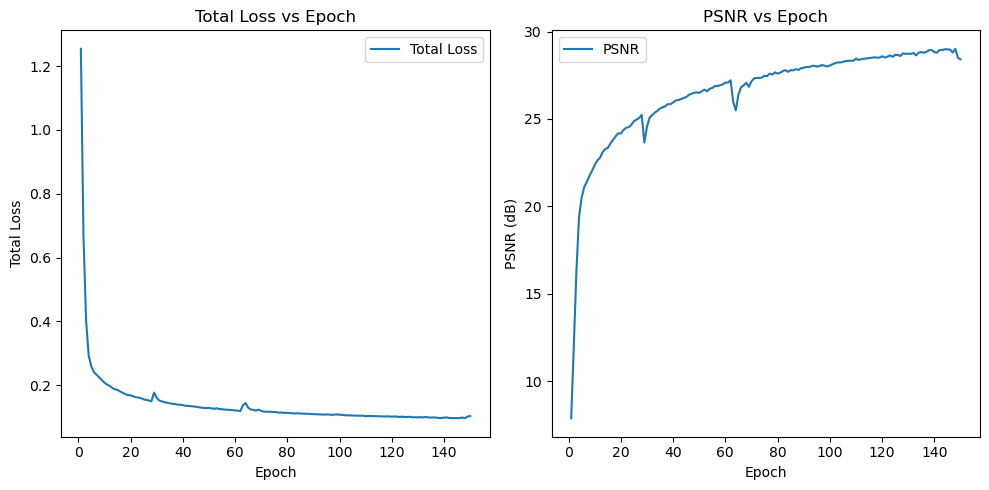

In [21]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

hr_patch_np = hr_patches_tensor[0].squeeze().cpu().numpy()
prediction_np = pred.squeeze().detach().cpu().numpy()


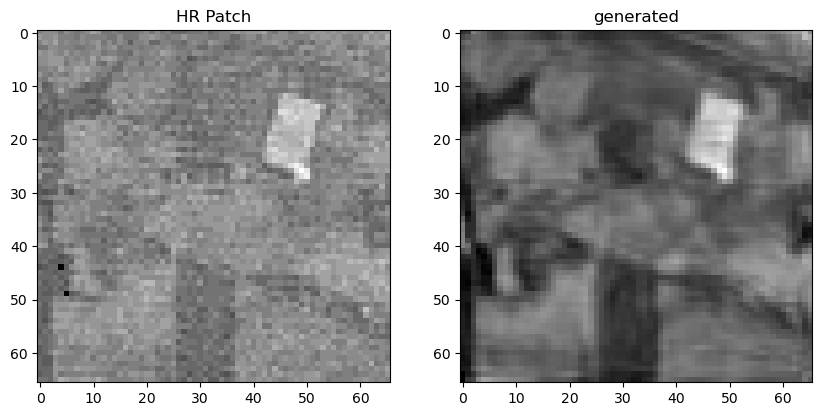

In [23]:
# Plotting HR patch and prediction side by side
plt.figure(figsize=(10, 5))

# Plot HR patch
plt.subplot(1, 2, 1)
plt.imshow(hr_patch_np[1,:,:], cmap='gray')
plt.title('HR Patch')

# Plot prediction
plt.subplot(1, 2, 2)
plt.imshow(prediction_np[1,:,:], cmap='gray')
plt.title('generated')

plt.show()

In [25]:
# Calculate RMSE, SSIM, and SAM
hr_patch_flat = hr_patch_np.flatten()
prediction_flat = prediction_np.flatten()

# Root Mean Squared Error (RMSE)
rmse = torch.sqrt(torch.mean((torch.tensor(hr_patch_flat) - torch.tensor(prediction_flat)) ** 2)).item()

# Structural Similarity Index (SSIM)
ssim_index = ssim(hr_patch_np, prediction_np, data_range=hr_patch_np.max())

# Spectral Angle Mapper (SAM)
cos_sim = np.dot(hr_patch_flat, prediction_flat) / (np.linalg.norm(hr_patch_flat) * np.linalg.norm(prediction_flat))
sam = np.arccos(np.clip(cos_sim, -1, 1)) * (180.0 / np.pi)

print(f"RMSE: {rmse:.6f}")
print(f"SSIM: {ssim_index:.6f}")
print(f"SAM: {sam:.6f} degrees")

RMSE: 0.046527
SSIM: 0.864878
SAM: 5.657696 degrees


In [26]:
torch.save(model.state_dict(), 'D:\\Hemanth\\SuperResolution\\Dong\\saved models\\SRCNN_150ep.pth')

# Testing on Test set

In [27]:
model.eval()

lr_patch = test_bilinear_lr_patches_tensor[20]
lr_patch_tensor = torch.tensor(lr_patch, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
  sr_patch = model(lr_patch_tensor)

sr_patch = sr_patch.cpu().squeeze().numpy()

lr_patch_np = lr_patch_tensor.squeeze().cpu().numpy()

C:\Users\DELL\AppData\Local\Temp\ipykernel_19620\3821556288.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lr_patch_tensor = torch.tensor(lr_patch, dtype=torch.float32).unsqueeze(0).to(device)


In [28]:
hr_patch = test_hr_patches_tensor[20]
hr_patch_tensor = torch.tensor(hr_patch, dtype=torch.float32).unsqueeze(0).to(device)
hr_patch_np = hr_patch_tensor.squeeze().cpu().numpy()

C:\Users\DELL\AppData\Local\Temp\ipykernel_19620\951927354.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hr_patch_tensor = torch.tensor(hr_patch, dtype=torch.float32).unsqueeze(0).to(device)


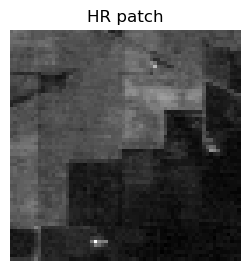

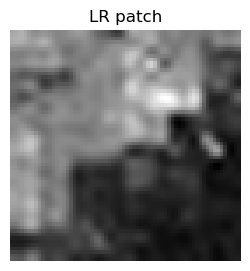

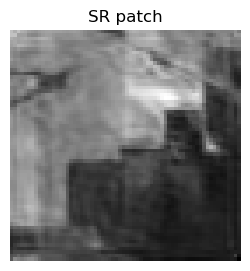

In [29]:
# Plot the HR patch
plt.figure(figsize=(3, 3))
plt.imshow(hr_patch_np[5, :, :], cmap='gray')
plt.title('HR patch')
plt.axis('off')
plt.show()

# Plot the LR patch
plt.figure(figsize=(3, 3))
plt.imshow(lr_patch_np[5,:,:], cmap='gray')
plt.title('LR patch')
plt.axis('off')
plt.show()

# Plot the SR patch
plt.figure(figsize=(3, 3))
plt.imshow(sr_patch[5,:,:], cmap='gray')
plt.title('SR patch')
plt.axis('off')
plt.show()

In [30]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

def psnr_rmse_sam(image1, image2):
    # Calculate PSNR and RMSE
    psnr = peak_signal_noise_ratio(image1, image2, data_range=hr_patch_np.max())
    rmse = np.sqrt(mean_squared_error(image1, image2))

    # Flatten the images
    image1_flat = image1.reshape(-1, 200)
    image2_flat = image2.reshape(-1, 200)

    # Calculate SAM
    numerator = np.sum(image1_flat * image2_flat, axis=1)
    denominator = np.sqrt(np.sum(image1_flat ** 2, axis=1) * np.sum(image2_flat ** 2, axis=1))
    sam = np.arccos(np.clip(numerator / denominator, -1.0, 1.0)) * (180 / np.pi)  # Convert to degrees

    return psnr, rmse, np.mean(sam)


psnr_value, rmse_value, sam_value = psnr_rmse_sam(hr_patch_np, sr_patch)
print("PSNR:", psnr_value)
print("RMSE:", rmse_value)
print("SAM:", sam_value)


PSNR: 27.441315563539945
RMSE: 0.04245552560010951
SAM: 5.3193474
